In [1]:
# enabling 3rd party widgets
# from google.colab import output
# output.enable_custom_widget_manager()
# output.disable_custom_widget_manager()

# interactive 3D plot
# !pip install ipympl
# %matplotlib widget

In [2]:
import os
import math
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

import time as time
import platform as platform

import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import L2
import h5py

tf.keras.backend.set_floatx('float32')

In [3]:
colab_flag = False
FTYPE = np.float32
ITYPE = np.int32

# strategy = None
strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


2022-11-11 17:21:10.791537: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-11 17:21:10.791772: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-11 17:21:10.823918: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-11 17:21:10.824153: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-11 17:21:10.824439: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

In [4]:
current_sys = platform.system()

if current_sys == 'Windows':
    dir_sep = '\\'
else:
    dir_sep = '/'

In [5]:
if colab_flag == True:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/Github/MLROM/KS/')

In [6]:
print(os.getcwd())

/home/rkaushik/Documents/Thesis/MLROM/KS


In [7]:
from tools.misc_tools import create_data_for_RNN, mytimecallback, SaveLosses, plot_losses, plot_reconstructed_data_KS, plot_latent_states_KS , readAndReturnLossHistories, sigmoidWarmupAndDecayLRSchedule
from tools.ae_v3 import Autoencoder
from tools.GRU_SingleStep_v6 import RNN_GRU

In [8]:
behaviour = 'initialiseAndTrainFromScratch'
# behaviour = 'loadCheckpointAndContinueTraining'
# behaviour = 'loadFinalNetAndPlot'

In [9]:
# setting seed for PRNGs
if behaviour == 'initialiseAndTrainFromScratch':
    prng_seed = 42
    np.random.seed(prng_seed)
    tf.random.set_seed(prng_seed)

In [10]:
gpus = tf.config.list_physical_devices('GPU')
print(gpus)

if colab_flag == False:
    if strategy is None:
        if gpus:
            gpu_to_use = 0
            tf.config.set_visible_devices(gpus[gpu_to_use], 'GPU')
    logical_devices = tf.config.list_logical_devices('GPU')
    print(logical_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU'), LogicalDevice(name='/device:GPU:1', device_type='GPU')]


In [11]:
# print(tf.test.gpu_device_name())
print(tf.config.list_physical_devices())
print(tf.config.list_logical_devices())
print(tf.__version__)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
[LogicalDevice(name='/device:CPU:0', device_type='CPU'), LogicalDevice(name='/device:GPU:0', device_type='GPU'), LogicalDevice(name='/device:GPU:1', device_type='GPU')]
2.8.1


# KS System

In [12]:
# setting up params (and saving, if applicable)
from numpy import *

if behaviour == 'initialiseAndTrainFromScratch':
    # making RNN save directory
    dir_name_rnn = os.getcwd() + dir_sep + 'saved_rnn'
    if not os.path.isdir(dir_name_rnn):
        os.makedirs(dir_name_rnn)

    counter = 0
    while True:
        dir_check = 'rnn_' + str(counter).zfill(3)
        if os.path.isdir(dir_name_rnn + dir_sep + dir_check):
            counter += 1
        else:
            break

    dir_name_rnn = dir_name_rnn + dir_sep + dir_check
    os.makedirs(dir_name_rnn)
    os.makedirs(dir_name_rnn+dir_sep+'plots')

    # autoencoder directory
    ae_idx = '020'
    dir_name_ae = os.getcwd()+'{ds}saved_ae{ds}ae_'.format(ds=dir_sep)+ae_idx
else:
    # RNN directory
    dir_name_rnn = os.getcwd()+'/saved_rnn/rnn_008'

    # reading AE directory
    with open(dir_name_rnn + '/sim_data_AE_params.txt') as f:
        lines = f.readlines()

    params_dict = eval(''.join(lines))

    dir_name_ae = params_dict['dir_name_ae']
    ae_idx = dir_name_ae[-3:]
    dir_name_ae = os.getcwd()+'/saved_ae/ae_'+ae_idx

    # reading RNN paramaters
    with open(dir_name_rnn + '/RNN_specific_data.txt') as f:
        lines = f.readlines()

    params_rnn_dict = eval(''.join(lines))

    dt_rnn = params_rnn_dict['dt_rnn']
    T_sample_input = params_rnn_dict['T_sample_input']
    T_sample_output = params_rnn_dict['T_sample_output']
    T_offset = params_rnn_dict['T_offset']
    return_params_arr = params_rnn_dict['return_params_arr']
    params = params_rnn_dict['params']
    try:
        normalize_dataset = params_rnn_dict['normalize_dataset']
    except:
        print("'normalize_dataset' not present in RNN_specific_data, set to False.")
        normalize_dataset = False
    try:
        stddev_multiplier = params_rnn_dict['stddev_multiplier']
    except:
        print("'stddev_multiplier' not present in RNN_specific_data, set to None.")
        stddev_multiplier = None
    try:
        skip_intermediate = params_rnn_dict['skip_intermediate']
    except:
        print("'skip_intermediate' not present in RNN_specific_data, set to 1.")
        skip_intermediate = 1

# reading simulation parameters
with open(dir_name_ae + dir_sep + 'ae_data.txt') as f:
    lines = f.readlines()
params_dict = eval(''.join(lines))
data_dir_idx = params_dict['data_dir_idx']
normalizeforae_flag = params_dict['normalizeforae_flag']
normalization_constant_arr_aedata = params_dict['normalization_constant_arr_aedata']

print('dir_name_rnn:', dir_name_rnn)
print('dir_name_ae:', dir_name_ae)
print('data_dir_idx:', data_dir_idx)

# loading data
dir_name_data = os.getcwd() + dir_sep + 'saved_data' + dir_sep + 'data_' + data_dir_idx
    
with open(dir_name_data + dir_sep + 'sim_data_params.txt') as f:
    lines = f.readlines()
params_dict = eval(''.join(lines))
params_mat = params_dict['params_mat']
# init_state = params_dict['init_state']
t0 = params_dict['t0']
T = params_dict['T']
delta_t = params_dict['delta_t']
numpoints_xgrid = params_dict['numpoints_xgrid']
length = params_dict['length']
return_params_arr = params_dict['return_params_arr']
normalize_flag_ogdata = params_dict['normalize_flag']
print('normalize_flag_ogdata:', normalize_flag_ogdata)
alldata_withparams_flag = params_dict['alldata_withparams_flag']

xgrid = length*np.linspace(0, 1, numpoints_xgrid)

fl = np.load(dir_name_data+dir_sep+'data.npz', allow_pickle=True)
all_data = fl['all_data']
boundary_idx_arr = fl['boundary_idx_arr']
normalization_constant_arr_ogdata = fl['normalization_constant_arr'][0]
initial_t0 = fl['initial_t0']
init_state_mat = fl['init_state_mat']

lyapunov_spectrum_mat = fl['lyapunov_spectrum_mat']

dir_name_rnn: /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019
dir_name_ae: /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_020
data_dir_idx: 004
normalize_flag_ogdata: False


In [13]:
lyapunov_time_arr = np.empty(shape=lyapunov_spectrum_mat.shape[0], dtype=FTYPE)
for i in range(lyapunov_spectrum_mat.shape[0]):
    lyapunov_time_arr[i] = 1/lyapunov_spectrum_mat[i, 0]
    print('Case : {}, lyapunov exponent : {}, lyapunov time : {}s'.format(i+1, lyapunov_spectrum_mat[i, 0], lyapunov_time_arr[i]))

Case : 1, lyapunov exponent : 0.06465670311438651, lyapunov time : 15.466300964355469s


In [14]:
def plot(
        boundary_idx_arr,
        delta_t,
        all_data,
        xgrid,
        xticks_snapto=20,
        num_yticks=11,
    ):

    n = len(boundary_idx_arr)
    # '''
    num_cols = 1
    num_rows = 1
    factor = 1
    # fig = plt.figure(figsize=(7.5*num_cols, 7.5*num_rows))

    num_modes = xgrid.shape[0]

    prev_idx = 0
    for i in range(len(boundary_idx_arr)):
        next_idx = boundary_idx_arr[i]
        fig, ax = plt.subplots(figsize=(factor*7.5*num_cols, factor*5.0*num_rows))
        N = next_idx - prev_idx
        input_time = np.arange(0, N)*delta_t

        im = ax.imshow(all_data[prev_idx:next_idx, 0:num_modes].transpose(), aspect='auto', origin='lower')
        num_xticks = 1 + int((N*delta_t + 0.5*xticks_snapto) // xticks_snapto)
        # xticks = np.linspace(0, N, num_xticks, dtype=np.int32)
        xticks = np.arange(0, N, int((xticks_snapto+0.5*delta_t)//delta_t))
        ax.set_xticks(ticks=xticks)
        ax.set_xticklabels(np.round(xticks*delta_t, 1))
        ax.tick_params(axis='x', rotation=270+45)

        yticks = np.linspace(0, 1, num_yticks)*(len(xgrid)-1)
        yticklabels = np.round(np.linspace(0, 1, yticks.shape[0])*xgrid[-1], 2)
        ax.set_yticks(ticks=yticks)
        ax.set_yticklabels(yticklabels)

        ax.set_xlabel('Time')
        ax.set_ylabel(r'$x$')
        # ax.title.set_text(r'Latent States')

        plt.colorbar(im)
        plt.show()
        print('')

        prev_idx = next_idx

    # '''

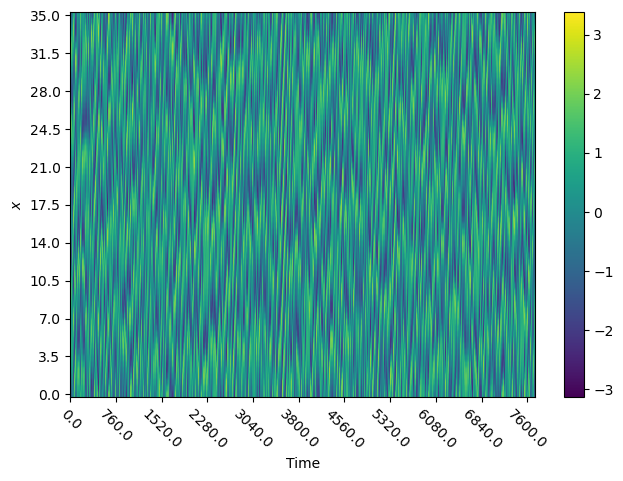

In [15]:
plot(
    boundary_idx_arr,
    delta_t,
    all_data,
    xgrid,
    xticks_snapto=int(40*np.round((T//10)/40))
)

In [16]:
# delaing with normalizing the data before feeding into autoencoder
if normalizeforae_flag == True:
    for i in range(numpoints_xgrid):
        all_data[:, i] -= normalization_constant_arr_aedata[0, i]
        all_data[:, i] /= normalization_constant_arr_aedata[1, i]

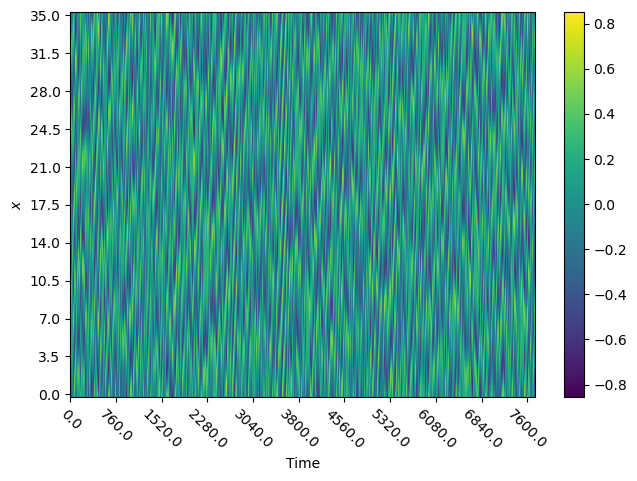

In [17]:
plot(
    boundary_idx_arr,
    delta_t,
    all_data,
    xgrid,
    xticks_snapto=int(40*np.round((T//10)/40))
)

# Autoencoder

In [18]:
# load_file = dir_name_ae+dir_sep+'new_class_data'+dir_sep+'ae_'+ae_idx+'_class_dict.txt'
# wt_file = dir_name_ae+dir_sep+'new_class_data'+dir_sep+'ae_'+ae_idx+'_ae_weights.h5'

# if colab_flag == False:
#     dir_name_ae_og = dir_name_ae
#     dir_name_ae_temp = '/home/rkaushik/Documents/Thesis/MLROM/CDV/saved_ae/ae_'+ae_idx
#     dir_name_ae = dir_name_ae_temp

load_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_class_dict.txt'
wt_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_ae_weights.h5'

# if colab_flag == False:
#     dir_name_ae = dir_name_ae_og

In [19]:
ae_net = Autoencoder(all_data.shape[1], load_file=load_file)
ae_net.load_weights_from_file(wt_file)

In [20]:
# create data
latent_states_all = ae_net.encoder_net.predict(all_data)
num_latent_states = latent_states_all.shape[1]

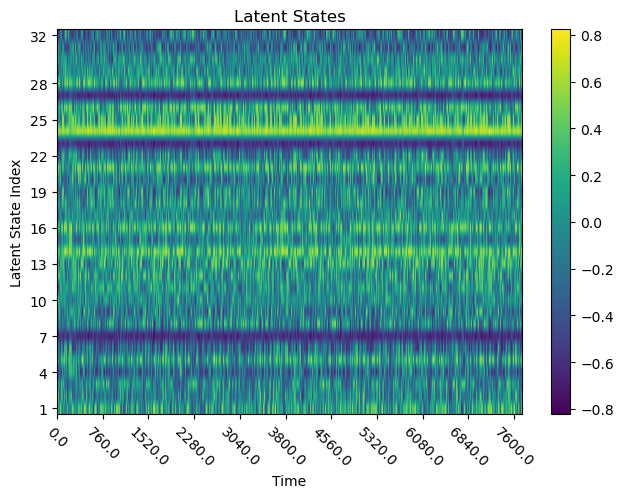

In [21]:
plot_latent_states_KS(
    boundary_idx_arr,
    latent_states_all,
    delta_t,
    dir_name_ae,
    xticks_snapto=int(40*np.round((T//10)/40)),
    num_yticks=11,
    save_figs=False)

In [22]:
# for i in range(ae_net.layers):
#     tf.keras.utils.plot_model(
#         ae_net.layers[i],
#         to_file=dir_name_ae+'/plots/netlayer_{}.png'.format(i),
#         show_shapes=True,
#         dpi=300
# )

# GRU

In [23]:
if behaviour == 'initialiseAndTrainFromScratch':
    # RNN data parameters
    num_lyaptimesteps_totrain = 5
    dt_rnn = 0.2
    T_sample_input = num_lyaptimesteps_totrain*np.mean(lyapunov_time_arr)
    T_sample_output = num_lyaptimesteps_totrain*np.mean(lyapunov_time_arr)
    T_offset = dt_rnn
    normalize_dataset = True # whether the data for the RNN should be normalized by the dataset's mean and std
    stddev_multiplier = 3
    skip_intermediate = 1/3
    if return_params_arr != False:
        params = params_arr
    else:
        params = None
        
    timeMeanofSpaceRMS = np.mean(np.mean(latent_states_all**2, axis=1)**0.5)

    # saving simulation data
    sim_data = {
        'params_mat':params_mat,
        'init_state_mat':init_state_mat,
        't0':t0,
        'T':T,
        'delta_t':delta_t,
        'return_params_arr':return_params_arr,
        'dir_name_ae':dir_name_ae,
        'normalize_dataset':normalize_dataset,
        'stddev_multiplier':stddev_multiplier,
    }


    with open(dir_name_rnn+dir_sep+'sim_data_AE_params.txt', 'w') as f:
        f.write(str(sim_data))
        
    # saving RNN specific data
    RNN_specific_data = {
        'dt_rnn':dt_rnn,
        'T_sample_input':T_sample_input,
        'T_sample_output':T_sample_output,
        'T_offset':T_offset,
        'boundary_idx_arr':boundary_idx_arr,
        'delta_t':delta_t,
        'params':params,
        'return_params_arr':return_params_arr,
        'normalize_dataset':normalize_dataset,
        'num_lyaptimesteps_totrain':num_lyaptimesteps_totrain,
        'stddev_multiplier':stddev_multiplier,
        'skip_intermediate':skip_intermediate,
    }

    with open(dir_name_rnn+dir_sep+'RNN_specific_data.txt', 'w') as f:
        f.write(str(RNN_specific_data))

In [24]:
rnn_res_dict = create_data_for_RNN(
    latent_states_all,
    dt_rnn,
    T_sample_input,
    T_sample_output,
    T_offset,
    None,
    boundary_idx_arr,
    delta_t,
    params=params,
    return_numsamples=True,
    normalize_dataset=normalize_dataset,
    stddev_multiplier=stddev_multiplier,
    skip_intermediate=skip_intermediate,
    return_OrgDataIdxArr=False)
    
data_rnn_input = rnn_res_dict['data_rnn_input']
data_rnn_output = rnn_res_dict['data_rnn_output']
org_data_idx_arr_input = rnn_res_dict['org_data_idx_arr_input']
org_data_idx_arr_output = rnn_res_dict['org_data_idx_arr_output']
num_samples = rnn_res_dict['num_samples']
normalization_arr = rnn_res_dict['normalization_arr']
rnn_data_boundary_idx_arr = rnn_res_dict['rnn_data_boundary_idx_arr']

In [25]:
del(org_data_idx_arr_input)
del(org_data_idx_arr_output)
del(latent_states_all)

In [26]:
# setting up training params
if behaviour == 'initialiseAndTrainFromScratch':
    learning_rate_dict = {
        'eta_begin':0.0001,
        'eta_high':0.001,
        'eta_low':0.00001
    }
    epochs = 2000
    patience = 25  # parameter for early stopping
    min_delta = 1e-6  # parameter for early stopping
    lambda_reg = 1e-4  # weight for regularizer
    train_split = 0.8
    val_split = 0.1
    test_split = 1 - train_split - val_split
    batch_size = 64
    fRMS = 0.025

    # saving training params
    training_specific_params = {
        'learning_rate_dict':learning_rate_dict,
        'epochs':epochs,
        'patience':patience,
        'min_delta':min_delta,
        'prng_seed':prng_seed,
        'train_split':train_split,
        'val_split':val_split,
        'batch_size':batch_size,
        'fRMS':fRMS
    }

    with open(dir_name_rnn+dir_sep+'training_specific_params.txt', 'w') as f:
        f.write(str(training_specific_params))
else:
    # dir_name_rnn_og = dir_name_rnn
    # dir_name_rnn_temp = '/home/rkaushik/Documents/Thesis/MLROM/CDV/saved_rnn/rnn_'+dir_name_rnn_og[-3:]
    # dir_name_rnn = dir_name_rnn_temp

    with open(dir_name_rnn + dir_sep + 'training_specific_params.txt') as f:
        lines = f.readlines()


    tparams_dict = eval(''.join(lines))

    learning_rate_dict = tparams_dict['learning_rate_dict']
    epochs = tparams_dict['epochs']
    patience = tparams_dict['patience']
    min_delta = tparams_dict['min_delta']
    prng_seed = tparams_dict['prng_seed']
    train_split = tparams_dict['train_split']
    val_split = tparams_dict['val_split']
    batch_size = tparams_dict['batch_size']

    test_split = 1 - train_split - val_split

    # setting seed for PRNGs
    np.random.seed(prng_seed)
    tf.random.set_seed(prng_seed)

In [27]:
# idx = np.arange(data_rnn_input.shape[0])
# np.random.shuffle(idx)
# boundary = int(np.round(train_split*data_rnn_input.shape[0]))

# training_data_rnn_input = data_rnn_input[idx[0:boundary]]
# training_data_rnn_output = data_rnn_output[idx[0:boundary]]

# testing_data_rnn_input = data_rnn_input[idx[boundary:]]
# testing_data_rnn_output = data_rnn_output[idx[boundary:]]

In [28]:
cum_samples = rnn_data_boundary_idx_arr[-1]
# idx = np.arange(cum_samples)
# np.random.shuffle(idx)
num_train = 0
num_val = 0
begin_idx = 0
for i in range(len(boundary_idx_arr)):
    num_samples = rnn_data_boundary_idx_arr[i] - begin_idx
    num_train += int( (1-test_split-val_split)*num_samples )
    num_val += int(val_split*num_samples)
    begin_idx = rnn_data_boundary_idx_arr[i]

# defining shapes
training_input_shape = [num_train]
training_input_shape.extend(data_rnn_input.shape[1:])

training_output_shape = [num_train]
training_output_shape.extend(data_rnn_output.shape[1:])

val_input_shape = [num_val]
val_input_shape.extend(data_rnn_input.shape[1:])

val_output_shape = [num_train]
val_output_shape.extend(data_rnn_output.shape[1:])

testing_input_shape = [cum_samples-num_train-num_val]
testing_input_shape.extend(data_rnn_input.shape[1:])

testing_output_shape = [cum_samples-num_train-num_val]
testing_output_shape.extend(data_rnn_output.shape[1:])

# defining required arrays
training_data_rnn_input = np.empty(shape=training_input_shape)
training_data_rnn_output = np.empty(shape=training_output_shape)

val_data_rnn_input = np.empty(shape=val_input_shape)
val_data_rnn_output = np.empty(shape=val_output_shape)

testing_data_rnn_input = np.empty(shape=testing_input_shape)
testing_data_rnn_output = np.empty(shape=testing_output_shape)

begin_idx = 0
training_data_rolling_count = 0
val_data_rolling_count = 0
testing_data_rolling_count = 0
for i in range(len(boundary_idx_arr)):
    idx = np.arange(begin_idx, rnn_data_boundary_idx_arr[i])
    # np.random.shuffle(idx)
    num_samples = idx.shape[0]
    num_train = int( (1-test_split-val_split)*num_samples )
    num_val = int(val_split*num_samples)

    training_data_rnn_input[training_data_rolling_count:training_data_rolling_count+num_train] = data_rnn_input[idx[0:num_train]]
    training_data_rnn_output[training_data_rolling_count:training_data_rolling_count+num_train] = data_rnn_output[idx[0:num_train]]
    training_data_rolling_count += num_train

    val_data_rnn_input[val_data_rolling_count:val_data_rolling_count+num_val] = data_rnn_input[idx[num_train:num_train+num_val]]
    val_data_rnn_output[val_data_rolling_count:val_data_rolling_count+num_val] = data_rnn_output[idx[num_train:num_train+num_val]]
    val_data_rolling_count += num_val

    num_test = num_samples-num_train-num_val+1
    testing_data_rnn_input[testing_data_rolling_count:testing_data_rolling_count+num_test] = data_rnn_input[idx[num_train+num_val:]]
    testing_data_rnn_output[testing_data_rolling_count:testing_data_rolling_count+num_test] = data_rnn_output[idx[num_train+num_val:]]
    testing_data_rolling_count += num_test

    begin_idx = rnn_data_boundary_idx_arr[i]

# further shuffling
idx = np.arange(0, training_data_rnn_input.shape[0])
np.random.shuffle(idx)
training_data_rnn_input = training_data_rnn_input[idx]
training_data_rnn_output = training_data_rnn_output[idx]

idx = np.arange(0, val_data_rnn_input.shape[0])
np.random.shuffle(idx)
val_data_rnn_input = val_data_rnn_input[idx]
val_data_rnn_output = val_data_rnn_output[idx]

idx = np.arange(0, testing_data_rnn_input.shape[0])
np.random.shuffle(idx)
testing_data_rnn_input = testing_data_rnn_input[idx]
testing_data_rnn_output = testing_data_rnn_output[idx]

In [29]:
del(data_rnn_input)
del(data_rnn_output)

In [30]:
# Initialize network
if behaviour == 'initialiseAndTrainFromScratch':
    rnn_layers_units = [2**9]*1
#     timeMeanofSpaceRMS = np.mean(np.mean(latent_states_all**2, axis=1)**0.5)
    stddev = fRMS*timeMeanofSpaceRMS
    print('timeMeanofSpaceRMS :', timeMeanofSpaceRMS)
    print('stddev :', stddev)
    if return_params_arr != False:
        data_dim = num_latent_states + 3
    else:
        data_dim = num_latent_states

    if strategy is not None:
        with strategy.scope():
            rnn_net = RNN_GRU(
                data_dim=data_dim,
            #     in_steps=int(T_sample_input // dt_rnn),
            #     out_steps=int(T_sample_output // dt_rnn),
                dt_rnn=dt_rnn,
                lambda_reg=lambda_reg,
                reg_name='L2',
                rnn_layers_units=rnn_layers_units,
                dense_layer_act_func='linear',
                load_file=None,
                # T_input=T_sample_input,
                # T_output=T_sample_output,
                stddev=stddev
            )
    else:
        rnn_net = RNN_GRU(
            data_dim=data_dim,
        #     in_steps=int(T_sample_input // dt_rnn),
        #     out_steps=int(T_sample_output // dt_rnn),
            dt_rnn=dt_rnn,
            lambda_reg=lambda_reg,
            reg_name='L2',
            rnn_layers_units=rnn_layers_units,
            dense_layer_act_func='linear',
            load_file=None,
            # T_input=T_sample_input,
            # T_output=T_sample_output,
            stddev=stddev
        )
    save_path = dir_name_rnn+dir_sep+'final_net'
    if not os.path.isdir(save_path):
        os.makedirs(save_path)
    rnn_net.save_class_dict(save_path+dir_sep+'final_net_class_dict.txt')
else:
    load_file = dir_name_rnn + dir_sep + 'final_net' + dir_sep + 'final_net_class_dict.txt'
    if strategy is not None:
        with strategy.scope():
            rnn_net = RNN_GRU(
                load_file=load_file,
                # T_input=T_sample_input,
                # T_output=T_sample_output
            )
    else:
        rnn_net = RNN_GRU(
            load_file=load_file,
            # T_input=T_sample_input,
            # T_output=T_sample_output
        )
    
    if behaviour == 'loadCheckpointAndContinueTraining':
        wt_file = tf.train.latest_checkpoint(dir_name_rnn+dir_sep+'checkpoints')
    elif behaviour == 'loadFinalNetAndPlot':
        wt_file = dir_name_rnn+dir_sep+'final_net'+dir_sep+'final_net_gru_weights.h5'
        # wt_file = dir_name_rnn+dir_sep+'final_net'+dir_sep+'f2'#+dir_sep+'saved_model.pb'
        rnn_net.load_weights_from_file(wt_file)
    
    # this forces the model to initialize its kernel weights/biases
    # temp = rnn_net.predict(tf.ones(shape=[batch_size, int(T_sample_input//dt_rnn), rnn_net.data_dim]))
    # this loads just the kernel wieghts and biases of the model
#     rnn_net.load_weights_from_file(wt_file)

    # rnn_net = tf.keras.models.load_model(wt_file)

timeMeanofSpaceRMS : 0.40322953
stddev : 0.010080738365650177


2022-11-11 17:21:23.085171: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_7925"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\021FlatMapDataset:18"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUC

In [31]:
if behaviour == 'initialiseAndTrainFromScratch':
    val_loss_hist = []
    train_loss_hist = []
    lr_change=[0, 0]
    savelosses_cb_vallossarr = np.ones(shape=epochs)*np.NaN
    savelosses_cb_trainlossarr = np.ones(shape=epochs)*np.NaN
    starting_lr_idx = 0
    num_epochs_left = epochs
    earlystopping_wait = 0
elif behaviour == 'loadCheckpointAndContinueTraining':
    val_loss_hist, train_loss_hist, lr_change, starting_lr_idx, num_epochs_left, val_loss_arr_fromckpt, train_loss_arr_fromckpt, earlystopping_wait = readAndReturnLossHistories(
        dir_name_ae=dir_name_rnn,
        dir_sep=dir_sep,
        epochs=epochs,
        learning_rate_list=[0],
        return_earlystopping_wait=True)
    savelosses_cb_vallossarr = val_loss_arr_fromckpt
    savelosses_cb_trainlossarr = train_loss_arr_fromckpt
elif behaviour == 'loadFinalNetAndPlot':
    with open(dir_name_rnn+'{ds}final_net{ds}losses.txt'.format(ds=dir_sep), 'r') as f:
        lines = f.readlines()
    
    losses_dict = eval(''.join(lines))

    val_loss_hist = losses_dict['val_loss_hist']
    train_loss_hist = losses_dict['train_loss_hist']
    lr_change = losses_dict['lr_change']
    test_loss = losses_dict['test_loss']

In [32]:
# compiling the network
rnn_net.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate_dict['eta_begin']),
    loss=losses.MeanSquaredError(),
    run_eagerly=False
)

if behaviour == 'loadCheckpointAndContinueTraining':
    # this loads the weights/attributes of the optimizer as well
    if strategy is not None:
        with strategy.scope():
            rnn_net.load_weights(wt_file)
    else:
        rnn_net.load_weights(wt_file)

if behaviour == 'initialiseAndTrainFromScratch' or behaviour == 'loadCheckpointAndContinueTraining':
    # implementing early stopping
    baseline = None
    if behaviour == 'loadCheckpointAndContinueTraining':
        baseline = np.min(val_loss_hist)
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=patience,
        restore_best_weights=True,
        verbose=True,
        min_delta=min_delta,
        baseline=baseline
    )
    # the below two lines are useless because wait is set to 0 in on_train_begin
    # early_stopping_cb.wait = earlystopping_wait
    # print('early_stopping_cb.wait : {}\n'.format(early_stopping_cb.wait))

    # time callback for each epoch
    timekeeper_cb = mytimecallback()

    # model checkpoint callback
    dir_name_ckpt = dir_name_rnn+dir_sep+'checkpoints'
    if not os.path.isdir(dir_name_ckpt):
        os.makedirs(dir_name_ckpt)
    checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
        filepath=dir_name_ckpt+dir_sep+'checkpoint',#+'/checkpoint--loss={loss:.4f}--vall_loss={val_loss:.4f}',
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=True,
        verbose=2,
        initial_value_threshold=baseline,
        period=1  # saves every `period` epochs
    )

    # save losses callback
    savelosses_cb = SaveLosses(
        filepath=dir_name_ckpt+dir_sep+'LossHistoriesCheckpoint',
        val_loss_arr=savelosses_cb_vallossarr,
        train_loss_arr=savelosses_cb_trainlossarr,
        total_epochs=epochs,
        period=1)
    
    # sigmoid annealing lr schedule
    lrschedule_cb = sigmoidWarmupAndDecayLRSchedule(
        eta_begin=learning_rate_dict['eta_begin'],
        eta_high=learning_rate_dict['eta_high'],
        eta_low=learning_rate_dict['eta_low'],
        warmup=40,
        expected_epochs=100,
        g_star=0.999,
        f_star=0.001
    )

    # training the network
    savelosses_cb.update_offset(epochs - num_epochs_left)
    
    history = rnn_net.fit(training_data_rnn_input, training_data_rnn_output,
        epochs=num_epochs_left,
        batch_size=batch_size,
        # validation_split=val_split/(train_split+val_split),
        validation_data=(val_data_rnn_input, val_data_rnn_output),
        callbacks=[early_stopping_cb, timekeeper_cb, checkpoint_cb, savelosses_cb, lrschedule_cb],
        verbose=1
    )

    val_loss_hist.extend(history.history['val_loss'])
    train_loss_hist.extend(history.history['loss'])

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
Epoch 1/2000


2022-11-11 17:21:25.465494: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_8528"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\021FlatMapDataset:45"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUC

INFO:tensorflow:batch_all_reduce: 6 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:batch_all_reduce: 6 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
2/2 [==============================] - ETA: 0s - loss: 0.1829  INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CP

2022-11-11 17:23:49.239674: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_178025"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\021FlatMapDataset:90"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PROD

 - tot_time: 0h 2m 57.2s

Epoch 1: val_loss improved from inf to 0.17908, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 177s 34s/step - loss: 0.1829 - val_loss: 0.1791
Epoch 2/2000
2/2 [==============================] - ETA: 0s - loss: 0.1761 - tot_time: 0h 2m 58.0s

Epoch 2: val_loss improved from 0.17908 to 0.17241, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 587ms/step - loss: 0.1761 - val_loss: 0.1724
Epoch 3/2000
2/2 [==============================] - ETA: 0s - loss: 0.1697 - tot_time: 0h 2m 58.9s

Epoch 3: val_loss improved from 0.17241 to 0.16605, saving

Epoch 19/2000
2/2 [==============================] - ETA: 0s - loss: 0.0854 - tot_time: 0h 3m 12.7s

Epoch 19: val_loss improved from 0.08602 to 0.08137, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 639ms/step - loss: 0.0854 - val_loss: 0.0814
Epoch 20/2000
2/2 [==============================] - ETA: 0s - loss: 0.0808 - tot_time: 0h 3m 13.7s

Epoch 20: val_loss improved from 0.08137 to 0.07779, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 555ms/step - loss: 0.0808 - val_loss: 0.0778
Epoch 21/2000
2/2 [==============================] - ETA: 0s - loss: 0.0772 

Epoch 37/2000
2/2 [==============================] - ETA: 0s - loss: 0.0595 - tot_time: 0h 3m 28.4s

Epoch 37: val_loss improved from 0.05973 to 0.05935, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 545ms/step - loss: 0.0595 - val_loss: 0.0593
Epoch 38/2000
2/2 [==============================] - ETA: 0s - loss: 0.0592 - tot_time: 0h 3m 29.3s

Epoch 38: val_loss improved from 0.05935 to 0.05902, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 585ms/step - loss: 0.0592 - val_loss: 0.0590
Epoch 39/2000
2/2 [==============================] - ETA: 0s - loss: 0.0588 

Epoch 55/2000
2/2 [==============================] - ETA: 0s - loss: 0.0547 - tot_time: 0h 3m 43.9s

Epoch 55: val_loss improved from 0.05488 to 0.05467, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 574ms/step - loss: 0.0547 - val_loss: 0.0547
Epoch 56/2000
2/2 [==============================] - ETA: 0s - loss: 0.0545 - tot_time: 0h 3m 44.8s

Epoch 56: val_loss improved from 0.05467 to 0.05446, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 554ms/step - loss: 0.0545 - val_loss: 0.0545
Epoch 57/2000
2/2 [==============================] - ETA: 0s - loss: 0.0543 

Epoch 73/2000
2/2 [==============================] - ETA: 0s - loss: 0.0513 - tot_time: 0h 3m 59.5s

Epoch 73: val_loss improved from 0.05143 to 0.05125, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 573ms/step - loss: 0.0513 - val_loss: 0.0513
Epoch 74/2000
2/2 [==============================] - ETA: 0s - loss: 0.0511 - tot_time: 0h 4m 0.4s

Epoch 74: val_loss improved from 0.05125 to 0.05108, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 555ms/step - loss: 0.0511 - val_loss: 0.0511
Epoch 75/2000
2/2 [==============================] - ETA: 0s - loss: 0.0510 -

Epoch 91/2000
2/2 [==============================] - ETA: 0s - loss: 0.0488 - tot_time: 0h 4m 15.4s

Epoch 91: val_loss improved from 0.04886 to 0.04877, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 531ms/step - loss: 0.0488 - val_loss: 0.0488
Epoch 92/2000
2/2 [==============================] - ETA: 0s - loss: 0.0487 - tot_time: 0h 4m 16.2s

Epoch 92: val_loss improved from 0.04877 to 0.04867, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 525ms/step - loss: 0.0487 - val_loss: 0.0487
Epoch 93/2000
2/2 [==============================] - ETA: 0s - loss: 0.0486 

Epoch 109/2000
2/2 [==============================] - ETA: 0s - loss: 0.0479 - tot_time: 0h 4m 30.8s

Epoch 109: val_loss improved from 0.04794 to 0.04792, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 522ms/step - loss: 0.0479 - val_loss: 0.0479
Epoch 110/2000
2/2 [==============================] - ETA: 0s - loss: 0.0478 - tot_time: 0h 4m 31.7s

Epoch 110: val_loss improved from 0.04792 to 0.04791, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 593ms/step - loss: 0.0478 - val_loss: 0.0479
Epoch 111/2000
2/2 [==============================] - ETA: 0s - loss: 0.

Epoch 127/2000
2/2 [==============================] - ETA: 0s - loss: 0.0477 - tot_time: 0h 4m 46.3s

Epoch 127: val_loss improved from 0.04779 to 0.04779, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 537ms/step - loss: 0.0477 - val_loss: 0.0478
Epoch 128/2000
2/2 [==============================] - ETA: 0s - loss: 0.0477 - tot_time: 0h 4m 47.2s

Epoch 128: val_loss improved from 0.04779 to 0.04778, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 547ms/step - loss: 0.0477 - val_loss: 0.0478
Epoch 129/2000
2/2 [==============================] - ETA: 0s - loss: 0.

Epoch 146/2000
2/2 [==============================] - ETA: 0s - loss: 0.0477 - tot_time: 0h 5m 2.2s

Epoch 146: val_loss improved from 0.04775 to 0.04775, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 550ms/step - loss: 0.0477 - val_loss: 0.0477
Epoch 147/2000
2/2 [==============================] - ETA: 0s - loss: 0.0477 - tot_time: 0h 5m 3.1s

Epoch 147: val_loss improved from 0.04775 to 0.04774, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 542ms/step - loss: 0.0477 - val_loss: 0.0477
Epoch 148/2000
2/2 [==============================] - ETA: 0s - loss: 0.04

Epoch 183/2000
2/2 [==============================] - ETA: 0s - loss: 0.0476 - tot_time: 0h 5m 33.4s

Epoch 183: val_loss improved from 0.04768 to 0.04767, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 528ms/step - loss: 0.0476 - val_loss: 0.0477
Epoch 184/2000
2/2 [==============================] - ETA: 0s - loss: 0.0476 - tot_time: 0h 5m 34.2s

Epoch 184: val_loss improved from 0.04767 to 0.04767, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 564ms/step - loss: 0.0476 - val_loss: 0.0477
Epoch 185/2000
2/2 [==============================] - ETA: 0s - loss: 0.

Epoch 201/2000
2/2 [==============================] - ETA: 0s - loss: 0.0476 - tot_time: 0h 5m 49.0s

Epoch 201: val_loss improved from 0.04764 to 0.04764, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 536ms/step - loss: 0.0476 - val_loss: 0.0476
Epoch 202/2000
2/2 [==============================] - ETA: 0s - loss: 0.0476 - tot_time: 0h 5m 49.8s

Epoch 202: val_loss improved from 0.04764 to 0.04764, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 509ms/step - loss: 0.0476 - val_loss: 0.0476
Epoch 203/2000
2/2 [==============================] - ETA: 0s - loss: 0.

Epoch 220/2000
2/2 [==============================] - ETA: 0s - loss: 0.0475 - tot_time: 0h 6m 4.9s

Epoch 220: val_loss improved from 0.04760 to 0.04760, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 519ms/step - loss: 0.0475 - val_loss: 0.0476
Epoch 221/2000
2/2 [==============================] - ETA: 0s - loss: 0.0475 - tot_time: 0h 6m 5.7s

Epoch 221: val_loss did not improve from 0.04760
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 482ms/step - loss: 0.0475 - val_loss: 0.0476
Epoch 222/2000
2/2 [==============================] - ETA: 0s - loss: 0.0475 - tot_time: 0h 6m 6.5s

Epoch 222: val_loss improved from 0.04760 to 0.04760, saving model to /home/

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 552ms/step - loss: 0.0475 - val_loss: 0.0476
Epoch 240/2000
2/2 [==============================] - ETA: 0s - loss: 0.0475 - tot_time: 0h 6m 21.6s

Epoch 240: val_loss did not improve from 0.04756
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 503ms/step - loss: 0.0475 - val_loss: 0.0476
Epoch 241/2000
2/2 [==============================] - ETA: 0s - loss: 0.0475 - tot_time: 0h 6m 22.4s

Epoch 241: val_loss improved from 0.04756 to 0.04756, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 591ms/step

Epoch 277/2000
2/2 [==============================] - ETA: 0s - loss: 0.0474 - tot_time: 0h 6m 53.0s

Epoch 277: val_loss did not improve from 0.04748
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 519ms/step - loss: 0.0474 - val_loss: 0.0475
Epoch 278/2000
2/2 [==============================] - ETA: 0s - loss: 0.0474 - tot_time: 0h 6m 53.7s

Epoch 278: val_loss improved from 0.04748 to 0.04748, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 515ms/step - loss: 0.0474 - val_loss: 0.0475
Epoch 279/2000
2/2 [==============================] - ETA: 0s - loss: 0.0474 - tot_time: 0h 6m 54.6s

Epoch 279: val_loss did not improve from 0.04748
 - saving loss histories

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 525ms/step - loss: 0.0474 - val_loss: 0.0474
Epoch 297/2000
2/2 [==============================] - ETA: 0s - loss: 0.0474 - tot_time: 0h 7m 9.4s

Epoch 297: val_loss improved from 0.04745 to 0.04744, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 566ms/step - loss: 0.0474 - val_loss: 0.0474
Epoch 298/2000
2/2 [==============================] - ETA: 0s - loss: 0.0474 - tot_time: 0h 7m 10.2s

Epoch 298: val_loss improved from 0.04744 to 0.04744, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/save

Epoch 315/2000
2/2 [==============================] - ETA: 0s - loss: 0.0473 - tot_time: 0h 7m 24.4s

Epoch 315: val_loss improved from 0.04741 to 0.04740, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 515ms/step - loss: 0.0473 - val_loss: 0.0474
Epoch 316/2000
2/2 [==============================] - ETA: 0s - loss: 0.0473 - tot_time: 0h 7m 25.3s

Epoch 316: val_loss improved from 0.04740 to 0.04740, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 577ms/step - loss: 0.0473 - val_loss: 0.0474
Epoch 317/2000
2/2 [==============================] - ETA: 0s - loss: 0.

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 530ms/step - loss: 0.0473 - val_loss: 0.0474
Epoch 334/2000
2/2 [==============================] - ETA: 0s - loss: 0.0473 - tot_time: 0h 7m 40.4s

Epoch 334: val_loss improved from 0.04736 to 0.04736, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 580ms/step - loss: 0.0473 - val_loss: 0.0474
Epoch 335/2000
2/2 [==============================] - ETA: 0s - loss: 0.0473 - tot_time: 0h 7m 41.4s

Epoch 335: val_loss improved from 0.04736 to 0.04736, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/sav

Epoch 353/2000
2/2 [==============================] - ETA: 0s - loss: 0.0472 - tot_time: 0h 7m 56.1s

Epoch 353: val_loss improved from 0.04732 to 0.04732, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 554ms/step - loss: 0.0472 - val_loss: 0.0473
Epoch 354/2000
2/2 [==============================] - ETA: 0s - loss: 0.0472 - tot_time: 0h 7m 56.9s

Epoch 354: val_loss improved from 0.04732 to 0.04732, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 523ms/step - loss: 0.0472 - val_loss: 0.0473
Epoch 355/2000
2/2 [==============================] - ETA: 0s - loss: 0.

Epoch 372/2000
2/2 [==============================] - ETA: 0s - loss: 0.0472 - tot_time: 0h 8m 11.8s

Epoch 372: val_loss improved from 0.04728 to 0.04728, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 509ms/step - loss: 0.0472 - val_loss: 0.0473
Epoch 373/2000
2/2 [==============================] - ETA: 0s - loss: 0.0472 - tot_time: 0h 8m 12.7s

Epoch 373: val_loss improved from 0.04728 to 0.04728, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 629ms/step - loss: 0.0472 - val_loss: 0.0473
Epoch 374/2000
2/2 [==============================] - ETA: 0s - loss: 0.

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 518ms/step - loss: 0.0472 - val_loss: 0.0472
Epoch 391/2000
2/2 [==============================] - ETA: 0s - loss: 0.0472 - tot_time: 0h 8m 27.9s

Epoch 391: val_loss did not improve from 0.04724
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 509ms/step - loss: 0.0472 - val_loss: 0.0472
Epoch 392/2000
2/2 [==============================] - ETA: 0s - loss: 0.0472 - tot_time: 0h 8m 28.8s

Epoch 392: val_loss improved from 0.04724 to 0.04724, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 566ms/step

Epoch 409/2000
2/2 [==============================] - ETA: 0s - loss: 0.0471 - tot_time: 0h 8m 43.2s

Epoch 409: val_loss improved from 0.04720 to 0.04719, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 551ms/step - loss: 0.0471 - val_loss: 0.0472
Epoch 410/2000
2/2 [==============================] - ETA: 0s - loss: 0.0471 - tot_time: 0h 8m 44.0s

Epoch 410: val_loss did not improve from 0.04719
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 487ms/step - loss: 0.0471 - val_loss: 0.0472
Epoch 411/2000
2/2 [==============================] - ETA: 0s - loss: 0.0471 - tot_time: 0h 8m 44.8s

Epoch 411: val_loss improved from 0.04719 to 0.04719, saving model to /ho

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 605ms/step - loss: 0.0471 - val_loss: 0.0472
Epoch 428/2000
2/2 [==============================] - ETA: 0s - loss: 0.0471 - tot_time: 0h 8m 59.4s

Epoch 428: val_loss improved from 0.04715 to 0.04715, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 571ms/step - loss: 0.0471 - val_loss: 0.0472
Epoch 429/2000
2/2 [==============================] - ETA: 0s - loss: 0.0471 - tot_time: 0h 9m 0.2s

Epoch 429: val_loss improved from 0.04715 to 0.04715, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/save

Epoch 447/2000
2/2 [==============================] - ETA: 0s - loss: 0.0470 - tot_time: 0h 9m 15.1s

Epoch 447: val_loss did not improve from 0.04711
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 485ms/step - loss: 0.0470 - val_loss: 0.0471
Epoch 448/2000
2/2 [==============================] - ETA: 0s - loss: 0.0470 - tot_time: 0h 9m 15.9s

Epoch 448: val_loss improved from 0.04711 to 0.04710, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 576ms/step - loss: 0.0470 - val_loss: 0.0471
Epoch 449/2000
2/2 [==============================] - ETA: 0s - loss: 0.0470 - tot_time: 0h 9m 16.8s

Epoch 449: val_loss improved from 0.04710 to 0.04710, saving model to /ho

Epoch 483/2000
2/2 [==============================] - ETA: 0s - loss: 0.0470 - tot_time: 0h 9m 45.7s

Epoch 483: val_loss did not improve from 0.04702
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 477ms/step - loss: 0.0470 - val_loss: 0.0470
Epoch 484/2000
2/2 [==============================] - ETA: 0s - loss: 0.0469 - tot_time: 0h 9m 46.6s

Epoch 484: val_loss improved from 0.04702 to 0.04702, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 628ms/step - loss: 0.0469 - val_loss: 0.0470
Epoch 485/2000
2/2 [==============================] - ETA: 0s - loss: 0.0469 - tot_time: 0h 9m 47.5s

Epoch 485: val_loss improved from 0.04702 to 0.04702, saving model to /ho

Epoch 501/2000
2/2 [==============================] - ETA: 0s - loss: 0.0469 - tot_time: 0h 10m 1.1s

Epoch 501: val_loss improved from 0.04698 to 0.04698, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 542ms/step - loss: 0.0469 - val_loss: 0.0470
Epoch 502/2000
2/2 [==============================] - ETA: 0s - loss: 0.0469 - tot_time: 0h 10m 2.0s

Epoch 502: val_loss improved from 0.04698 to 0.04698, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 525ms/step - loss: 0.0469 - val_loss: 0.0470
Epoch 503/2000
2/2 [==============================] - ETA: 0s - loss: 0.

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 459ms/step - loss: 0.0469 - val_loss: 0.0469
Epoch 520/2000
2/2 [==============================] - ETA: 0s - loss: 0.0469 - tot_time: 0h 10m 17.0s

Epoch 520: val_loss improved from 0.04693 to 0.04693, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 550ms/step - loss: 0.0469 - val_loss: 0.0469
Epoch 521/2000
2/2 [==============================] - ETA: 0s - loss: 0.0469 - tot_time: 0h 10m 17.9s

Epoch 521: val_loss improved from 0.04693 to 0.04693, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/s

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 518ms/step - loss: 0.0468 - val_loss: 0.0469
Epoch 538/2000
2/2 [==============================] - ETA: 0s - loss: 0.0468 - tot_time: 0h 10m 32.5s

Epoch 538: val_loss improved from 0.04689 to 0.04689, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 509ms/step - loss: 0.0468 - val_loss: 0.0469
Epoch 539/2000
2/2 [==============================] - ETA: 0s - loss: 0.0468 - tot_time: 0h 10m 33.3s

Epoch 539: val_loss improved from 0.04689 to 0.04689, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/s

Epoch 556/2000
2/2 [==============================] - ETA: 0s - loss: 0.0468 - tot_time: 0h 10m 47.5s

Epoch 556: val_loss improved from 0.04685 to 0.04684, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 655ms/step - loss: 0.0468 - val_loss: 0.0468
Epoch 557/2000
2/2 [==============================] - ETA: 0s - loss: 0.0468 - tot_time: 0h 10m 48.4s

Epoch 557: val_loss did not improve from 0.04684
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 456ms/step - loss: 0.0468 - val_loss: 0.0468
Epoch 558/2000
2/2 [==============================] - ETA: 0s - loss: 0.0468 - tot_time: 0h 10m 49.1s

Epoch 558: val_loss improved from 0.04684 to 0.04684, saving model to 

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 527ms/step - loss: 0.0467 - val_loss: 0.0468
Epoch 593/2000
2/2 [==============================] - ETA: 0s - loss: 0.0467 - tot_time: 0h 11m 18.9s

Epoch 593: val_loss improved from 0.04675 to 0.04675, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 582ms/step - loss: 0.0467 - val_loss: 0.0468
Epoch 594/2000
2/2 [==============================] - ETA: 0s - loss: 0.0467 - tot_time: 0h 11m 19.7s

Epoch 594: val_loss improved from 0.04675 to 0.04675, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/s

Epoch 611/2000
2/2 [==============================] - ETA: 0s - loss: 0.0466 - tot_time: 0h 11m 34.0s

Epoch 611: val_loss improved from 0.04671 to 0.04671, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 585ms/step - loss: 0.0466 - val_loss: 0.0467
Epoch 612/2000
2/2 [==============================] - ETA: 0s - loss: 0.0466 - tot_time: 0h 11m 34.8s

Epoch 612: val_loss did not improve from 0.04671
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 482ms/step - loss: 0.0466 - val_loss: 0.0467
Epoch 613/2000
2/2 [==============================] - ETA: 0s - loss: 0.0466 - tot_time: 0h 11m 35.6s

Epoch 613: val_loss improved from 0.04671 to 0.04670, saving model to 

Epoch 630/2000
2/2 [==============================] - ETA: 0s - loss: 0.0466 - tot_time: 0h 11m 49.7s

Epoch 630: val_loss did not improve from 0.04666
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 468ms/step - loss: 0.0466 - val_loss: 0.0467
Epoch 631/2000
2/2 [==============================] - ETA: 0s - loss: 0.0466 - tot_time: 0h 11m 50.5s

Epoch 631: val_loss improved from 0.04666 to 0.04666, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 559ms/step - loss: 0.0466 - val_loss: 0.0467
Epoch 632/2000
2/2 [==============================] - ETA: 0s - loss: 0.0466 - tot_time: 0h 11m 51.3s

Epoch 632: val_loss did not improve from 0.04666
 - saving loss histor

Epoch 649/2000
2/2 [==============================] - ETA: 0s - loss: 0.0465 - tot_time: 0h 12m 5.7s

Epoch 649: val_loss improved from 0.04661 to 0.04661, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 533ms/step - loss: 0.0465 - val_loss: 0.0466
Epoch 650/2000
2/2 [==============================] - ETA: 0s - loss: 0.0465 - tot_time: 0h 12m 6.5s

Epoch 650: val_loss did not improve from 0.04661
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 472ms/step - loss: 0.0465 - val_loss: 0.0466
Epoch 651/2000
2/2 [==============================] - ETA: 0s - loss: 0.0465 - tot_time: 0h 12m 7.3s

Epoch 651: val_loss improved from 0.04661 to 0.04661, saving model to /ho

Epoch 668/2000
2/2 [==============================] - ETA: 0s - loss: 0.0465 - tot_time: 0h 12m 21.3s

Epoch 668: val_loss improved from 0.04657 to 0.04656, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 542ms/step - loss: 0.0465 - val_loss: 0.0466
Epoch 669/2000
2/2 [==============================] - ETA: 0s - loss: 0.0465 - tot_time: 0h 12m 22.1s

Epoch 669: val_loss improved from 0.04656 to 0.04656, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 579ms/step - loss: 0.0465 - val_loss: 0.0466
Epoch 670/2000
2/2 [==============================] - ETA: 0s - loss: 

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 510ms/step - loss: 0.0464 - val_loss: 0.0465
Epoch 705/2000
2/2 [==============================] - ETA: 0s - loss: 0.0464 - tot_time: 0h 12m 52.2s

Epoch 705: val_loss did not improve from 0.04647
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 463ms/step - loss: 0.0464 - val_loss: 0.0465
Epoch 706/2000
2/2 [==============================] - ETA: 0s - loss: 0.0464 - tot_time: 0h 12m 53.0s

Epoch 706: val_loss improved from 0.04647 to 0.04646, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 557ms/st

Epoch 723/2000
2/2 [==============================] - ETA: 0s - loss: 0.0464 - tot_time: 0h 13m 7.3s

Epoch 723: val_loss improved from 0.04642 to 0.04642, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 569ms/step - loss: 0.0464 - val_loss: 0.0464
Epoch 724/2000
2/2 [==============================] - ETA: 0s - loss: 0.0463 - tot_time: 0h 13m 8.3s

Epoch 724: val_loss improved from 0.04642 to 0.04642, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 564ms/step - loss: 0.0463 - val_loss: 0.0464
Epoch 725/2000
2/2 [==============================] - ETA: 0s - loss: 0.

Epoch 741/2000
2/2 [==============================] - ETA: 0s - loss: 0.0463 - tot_time: 0h 13m 22.7s

Epoch 741: val_loss improved from 0.04638 to 0.04637, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 568ms/step - loss: 0.0463 - val_loss: 0.0464
Epoch 742/2000
2/2 [==============================] - ETA: 0s - loss: 0.0463 - tot_time: 0h 13m 23.6s

Epoch 742: val_loss improved from 0.04637 to 0.04637, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 563ms/step - loss: 0.0463 - val_loss: 0.0464
Epoch 743/2000
2/2 [==============================] - ETA: 0s - loss: 

2/2 [==============================] - ETA: 0s - loss: 0.0462 - tot_time: 0h 13m 53.4s

Epoch 777: val_loss improved from 0.04628 to 0.04628, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 523ms/step - loss: 0.0462 - val_loss: 0.0463
Epoch 778/2000
2/2 [==============================] - ETA: 0s - loss: 0.0462 - tot_time: 0h 13m 54.2s

Epoch 778: val_loss improved from 0.04628 to 0.04628, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 537ms/step - loss: 0.0462 - val_loss: 0.0463
Epoch 779/2000
2/2 [==============================] - ETA: 0s - loss: 0.0462 - tot_ti

2/2 [==============================] - ETA: 0s - loss: 0.0461 - tot_time: 0h 14m 23.8s

Epoch 813: val_loss did not improve from 0.04618
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 500ms/step - loss: 0.0461 - val_loss: 0.0462
Epoch 814/2000
2/2 [==============================] - ETA: 0s - loss: 0.0461 - tot_time: 0h 14m 24.6s

Epoch 814: val_loss improved from 0.04618 to 0.04618, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 546ms/step - loss: 0.0461 - val_loss: 0.0462
Epoch 815/2000
2/2 [==============================] - ETA: 0s - loss: 0.0461 - tot_time: 0h 14m 25.5s

Epoch 815: val_loss improved from 0.04618 to 0.04618, saving model to /home/rkaushik/

Epoch 831/2000
2/2 [==============================] - ETA: 0s - loss: 0.0461 - tot_time: 0h 14m 39.0s

Epoch 831: val_loss did not improve from 0.04613
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 476ms/step - loss: 0.0461 - val_loss: 0.0461
Epoch 832/2000
2/2 [==============================] - ETA: 0s - loss: 0.0461 - tot_time: 0h 14m 39.8s

Epoch 832: val_loss improved from 0.04613 to 0.04613, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 512ms/step - loss: 0.0461 - val_loss: 0.0461
Epoch 833/2000
2/2 [==============================] - ETA: 0s - loss: 0.0461 - tot_time: 0h 14m 40.6s

Epoch 833: val_loss improved from 0.04613 to 0.04613, saving model to 

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 534ms/step - loss: 0.0460 - val_loss: 0.0460
Epoch 868/2000
2/2 [==============================] - ETA: 0s - loss: 0.0460 - tot_time: 0h 15m 9.8s

Epoch 868: val_loss improved from 0.04603 to 0.04603, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 573ms/step - loss: 0.0460 - val_loss: 0.0460
Epoch 869/2000
2/2 [==============================] - ETA: 0s - loss: 0.0460 - tot_time: 0h 15m 10.6s

Epoch 869: val_loss improved from 0.04603 to 0.04603, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/sa

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 504ms/step - loss: 0.0459 - val_loss: 0.0460
Epoch 887/2000
2/2 [==============================] - ETA: 0s - loss: 0.0459 - tot_time: 0h 15m 25.1s

Epoch 887: val_loss improved from 0.04599 to 0.04598, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 512ms/step - loss: 0.0459 - val_loss: 0.0460
Epoch 888/2000
2/2 [==============================] - ETA: 0s - loss: 0.0459 - tot_time: 0h 15m 26.0s

Epoch 888: val_loss improved from 0.04598 to 0.04598, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/s

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 624ms/step - loss: 0.0459 - val_loss: 0.0459
Epoch 905/2000
2/2 [==============================] - ETA: 0s - loss: 0.0459 - tot_time: 0h 15m 40.3s

Epoch 905: val_loss did not improve from 0.04593
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 462ms/step - loss: 0.0459 - val_loss: 0.0459
Epoch 906/2000
2/2 [==============================] - ETA: 0s - loss: 0.0459 - tot_time: 0h 15m 41.1s

Epoch 906: val_loss improved from 0.04593 to 0.04593, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 590ms/st

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 559ms/step - loss: 0.0458 - val_loss: 0.0459
Epoch 923/2000
2/2 [==============================] - ETA: 0s - loss: 0.0458 - tot_time: 0h 15m 55.4s

Epoch 923: val_loss improved from 0.04588 to 0.04588, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 2s 2s/step - loss: 0.0458 - val_loss: 0.0459
Epoch 924/2000
2/2 [==============================] - ETA: 0s - loss: 0.0458 - tot_time: 0h 15m 57.8s

Epoch 924: val_loss improved from 0.04588 to 0.04588, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/save

Epoch 941/2000
2/2 [==============================] - ETA: 0s - loss: 0.0458 - tot_time: 0h 16m 12.2s

Epoch 941: val_loss improved from 0.04583 to 0.04583, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 633ms/step - loss: 0.0458 - val_loss: 0.0458
Epoch 942/2000
2/2 [==============================] - ETA: 0s - loss: 0.0458 - tot_time: 0h 16m 13.0s

Epoch 942: val_loss improved from 0.04583 to 0.04583, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 516ms/step - loss: 0.0458 - val_loss: 0.0458
Epoch 943/2000
2/2 [==============================] - ETA: 0s - loss: 

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 527ms/step - loss: 0.0457 - val_loss: 0.0458
Epoch 960/2000
2/2 [==============================] - ETA: 0s - loss: 0.0457 - tot_time: 0h 16m 27.8s

Epoch 960: val_loss improved from 0.04578 to 0.04578, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 495ms/step - loss: 0.0457 - val_loss: 0.0458
Epoch 961/2000
2/2 [==============================] - ETA: 0s - loss: 0.0457 - tot_time: 0h 16m 28.6s

Epoch 961: val_loss improved from 0.04578 to 0.04578, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/s

Epoch 978/2000
2/2 [==============================] - ETA: 0s - loss: 0.0457 - tot_time: 0h 16m 44.1s

Epoch 978: val_loss improved from 0.04573 to 0.04573, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 537ms/step - loss: 0.0457 - val_loss: 0.0457
Epoch 979/2000
2/2 [==============================] - ETA: 0s - loss: 0.0457 - tot_time: 0h 16m 44.9s

Epoch 979: val_loss improved from 0.04573 to 0.04572, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 521ms/step - loss: 0.0457 - val_loss: 0.0457
Epoch 980/2000
2/2 [==============================] - ETA: 0s - loss: 

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 508ms/step - loss: 0.0456 - val_loss: 0.0456
Epoch 1015/2000
2/2 [==============================] - ETA: 0s - loss: 0.0456 - tot_time: 0h 17m 14.8s

Epoch 1015: val_loss did not improve from 0.04562
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 505ms/step - loss: 0.0456 - val_loss: 0.0456
Epoch 1016/2000
2/2 [==============================] - ETA: 0s - loss: 0.0456 - tot_time: 0h 17m 15.6s

Epoch 1016: val_loss improved from 0.04562 to 0.04562, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 646m

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 533ms/step - loss: 0.0455 - val_loss: 0.0456
Epoch 1033/2000
2/2 [==============================] - ETA: 0s - loss: 0.0455 - tot_time: 0h 17m 30.1s

Epoch 1033: val_loss improved from 0.04558 to 0.04557, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 519ms/step - loss: 0.0455 - val_loss: 0.0456
Epoch 1034/2000
2/2 [==============================] - ETA: 0s - loss: 0.0455 - tot_time: 0h 17m 30.9s

Epoch 1034: val_loss improved from 0.04557 to 0.04557, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/

Epoch 1051/2000
2/2 [==============================] - ETA: 0s - loss: 0.0455 - tot_time: 0h 17m 45.4s

Epoch 1051: val_loss did not improve from 0.04552
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 503ms/step - loss: 0.0455 - val_loss: 0.0455
Epoch 1052/2000
2/2 [==============================] - ETA: 0s - loss: 0.0455 - tot_time: 0h 17m 46.2s

Epoch 1052: val_loss improved from 0.04552 to 0.04552, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 515ms/step - loss: 0.0455 - val_loss: 0.0455
Epoch 1053/2000
2/2 [==============================] - ETA: 0s - loss: 0.0454 - tot_time: 0h 17m 47.0s

Epoch 1053: val_loss improved from 0.04552 to 0.04551, saving mod

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 525ms/step - loss: 0.0454 - val_loss: 0.0455
Epoch 1070/2000
2/2 [==============================] - ETA: 0s - loss: 0.0454 - tot_time: 0h 18m 1.2s

Epoch 1070: val_loss improved from 0.04547 to 0.04547, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 532ms/step - loss: 0.0454 - val_loss: 0.0455
Epoch 1071/2000
2/2 [==============================] - ETA: 0s - loss: 0.0454 - tot_time: 0h 18m 2.1s

Epoch 1071: val_loss improved from 0.04547 to 0.04546, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS

2/2 [==============================] - ETA: 0s - loss: 0.0453 - tot_time: 0h 18m 30.8s

Epoch 1105: val_loss improved from 0.04537 to 0.04537, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 586ms/step - loss: 0.0453 - val_loss: 0.0454
Epoch 1106/2000
2/2 [==============================] - ETA: 0s - loss: 0.0453 - tot_time: 0h 18m 31.7s

Epoch 1106: val_loss improved from 0.04537 to 0.04536, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 531ms/step - loss: 0.0453 - val_loss: 0.0454
Epoch 1107/2000
2/2 [==============================] - ETA: 0s - loss: 0.0453 - to

2/2 [==============================] - ETA: 0s - loss: 0.0452 - tot_time: 0h 18m 45.9s

Epoch 1123: val_loss improved from 0.04531 to 0.04531, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 527ms/step - loss: 0.0452 - val_loss: 0.0453
Epoch 1124/2000
2/2 [==============================] - ETA: 0s - loss: 0.0452 - tot_time: 0h 18m 46.7s

Epoch 1124: val_loss improved from 0.04531 to 0.04531, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 505ms/step - loss: 0.0452 - val_loss: 0.0453
Epoch 1125/2000
2/2 [==============================] - ETA: 0s - loss: 0.0452 - to

Epoch 1141/2000
2/2 [==============================] - ETA: 0s - loss: 0.0452 - tot_time: 0h 19m 0.7s

Epoch 1141: val_loss improved from 0.04526 to 0.04526, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 490ms/step - loss: 0.0452 - val_loss: 0.0453
Epoch 1142/2000
2/2 [==============================] - ETA: 0s - loss: 0.0452 - tot_time: 0h 19m 1.5s

Epoch 1142: val_loss improved from 0.04526 to 0.04526, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 567ms/step - loss: 0.0452 - val_loss: 0.0453
Epoch 1143/2000
2/2 [==============================] - ETA: 0s - los

Epoch 1159/2000
2/2 [==============================] - ETA: 0s - loss: 0.0451 - tot_time: 0h 19m 15.6s

Epoch 1159: val_loss improved from 0.04521 to 0.04521, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 520ms/step - loss: 0.0451 - val_loss: 0.0452
Epoch 1160/2000
2/2 [==============================] - ETA: 0s - loss: 0.0451 - tot_time: 0h 19m 16.4s

Epoch 1160: val_loss improved from 0.04521 to 0.04521, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 509ms/step - loss: 0.0451 - val_loss: 0.0452
Epoch 1161/2000
2/2 [==============================] - ETA: 0s - l

Epoch 1177/2000
2/2 [==============================] - ETA: 0s - loss: 0.0451 - tot_time: 0h 19m 30.8s

Epoch 1177: val_loss improved from 0.04516 to 0.04516, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 577ms/step - loss: 0.0451 - val_loss: 0.0452
Epoch 1178/2000
2/2 [==============================] - ETA: 0s - loss: 0.0451 - tot_time: 0h 19m 31.6s

Epoch 1178: val_loss improved from 0.04516 to 0.04516, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 509ms/step - loss: 0.0451 - val_loss: 0.0452
Epoch 1179/2000
2/2 [==============================] - ETA: 0s - l

Epoch 1195/2000
2/2 [==============================] - ETA: 0s - loss: 0.0450 - tot_time: 0h 19m 45.8s

Epoch 1195: val_loss improved from 0.04511 to 0.04510, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 550ms/step - loss: 0.0450 - val_loss: 0.0451
Epoch 1196/2000
2/2 [==============================] - ETA: 0s - loss: 0.0450 - tot_time: 0h 19m 46.6s

Epoch 1196: val_loss improved from 0.04510 to 0.04510, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 516ms/step - loss: 0.0450 - val_loss: 0.0451
Epoch 1197/2000
2/2 [==============================] - ETA: 0s - l

Epoch 1213/2000
2/2 [==============================] - ETA: 0s - loss: 0.0450 - tot_time: 0h 20m 0.6s

Epoch 1213: val_loss improved from 0.04506 to 0.04505, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 531ms/step - loss: 0.0450 - val_loss: 0.0451
Epoch 1214/2000
2/2 [==============================] - ETA: 0s - loss: 0.0450 - tot_time: 0h 20m 1.5s

Epoch 1214: val_loss improved from 0.04505 to 0.04505, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 549ms/step - loss: 0.0450 - val_loss: 0.0450
Epoch 1215/2000
2/2 [==============================] - ETA: 0s - los

2/2 [==============================] - ETA: 0s - loss: 0.0449 - tot_time: 0h 20m 15.4s

Epoch 1231: val_loss improved from 0.04500 to 0.04499, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 543ms/step - loss: 0.0449 - val_loss: 0.0450
Epoch 1232/2000
2/2 [==============================] - ETA: 0s - loss: 0.0449 - tot_time: 0h 20m 16.2s

Epoch 1232: val_loss improved from 0.04499 to 0.04499, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 500ms/step - loss: 0.0449 - val_loss: 0.0450
Epoch 1233/2000
2/2 [==============================] - ETA: 0s - loss: 0.0449 - to

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 549ms/step - loss: 0.0449 - val_loss: 0.0449
Epoch 1250/2000
2/2 [==============================] - ETA: 0s - loss: 0.0449 - tot_time: 0h 20m 31.4s

Epoch 1250: val_loss improved from 0.04494 to 0.04494, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 543ms/step - loss: 0.0449 - val_loss: 0.0449
Epoch 1251/2000
2/2 [==============================] - ETA: 0s - loss: 0.0449 - tot_time: 0h 20m 32.2s

Epoch 1251: val_loss improved from 0.04494 to 0.04494, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 494ms/step - loss: 0.0448 - val_loss: 0.0449
Epoch 1268/2000
2/2 [==============================] - ETA: 0s - loss: 0.0448 - tot_time: 0h 20m 46.4s

Epoch 1268: val_loss improved from 0.04489 to 0.04489, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 565ms/step - loss: 0.0448 - val_loss: 0.0449
Epoch 1269/2000
2/2 [==============================] - ETA: 0s - loss: 0.0448 - tot_time: 0h 20m 47.2s

Epoch 1269: val_loss improved from 0.04489 to 0.04489, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 490ms/step - loss: 0.0448 - val_loss: 0.0448
Epoch 1286/2000
2/2 [==============================] - ETA: 0s - loss: 0.0448 - tot_time: 0h 21m 1.7s

Epoch 1286: val_loss did not improve from 0.04484
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 479ms/step - loss: 0.0448 - val_loss: 0.0448
Epoch 1287/2000
2/2 [==============================] - ETA: 0s - loss: 0.0448 - tot_time: 0h 21m 2.5s

Epoch 1287: val_loss improved from 0.04484 to 0.04483, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 531ms/

Epoch 1304/2000
2/2 [==============================] - ETA: 0s - loss: 0.0447 - tot_time: 0h 21m 16.7s

Epoch 1304: val_loss improved from 0.04479 to 0.04478, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 645ms/step - loss: 0.0447 - val_loss: 0.0448
Epoch 1305/2000
2/2 [==============================] - ETA: 0s - loss: 0.0447 - tot_time: 0h 21m 17.6s

Epoch 1305: val_loss improved from 0.04478 to 0.04478, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 611ms/step - loss: 0.0447 - val_loss: 0.0448
Epoch 1306/2000
2/2 [==============================] - ETA: 0s - l

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 582ms/step - loss: 0.0447 - val_loss: 0.0447
Epoch 1322/2000
2/2 [==============================] - ETA: 0s - loss: 0.0447 - tot_time: 0h 21m 32.4s

Epoch 1322: val_loss improved from 0.04473 to 0.04473, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 581ms/step - loss: 0.0447 - val_loss: 0.0447
Epoch 1323/2000
2/2 [==============================] - ETA: 0s - loss: 0.0447 - tot_time: 0h 21m 33.2s

Epoch 1323: val_loss improved from 0.04473 to 0.04472, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/

Epoch 1357/2000
2/2 [==============================] - ETA: 0s - loss: 0.0446 - tot_time: 0h 22m 1.8s

Epoch 1357: val_loss improved from 0.04462 to 0.04462, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 537ms/step - loss: 0.0446 - val_loss: 0.0446
Epoch 1358/2000
2/2 [==============================] - ETA: 0s - loss: 0.0446 - tot_time: 0h 22m 2.7s

Epoch 1358: val_loss improved from 0.04462 to 0.04462, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 544ms/step - loss: 0.0446 - val_loss: 0.0446
Epoch 1359/2000
2/2 [==============================] - ETA: 0s - los

Epoch 1375/2000
2/2 [==============================] - ETA: 0s - loss: 0.0445 - tot_time: 0h 22m 17.0s

Epoch 1375: val_loss improved from 0.04457 to 0.04457, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 527ms/step - loss: 0.0445 - val_loss: 0.0446
Epoch 1376/2000
2/2 [==============================] - ETA: 0s - loss: 0.0445 - tot_time: 0h 22m 17.8s

Epoch 1376: val_loss improved from 0.04457 to 0.04456, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 503ms/step - loss: 0.0445 - val_loss: 0.0446
Epoch 1377/2000
2/2 [==============================] - ETA: 0s - l

Epoch 1393/2000
2/2 [==============================] - ETA: 0s - loss: 0.0445 - tot_time: 0h 22m 32.4s

Epoch 1393: val_loss improved from 0.04452 to 0.04451, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 581ms/step - loss: 0.0445 - val_loss: 0.0445
Epoch 1394/2000
2/2 [==============================] - ETA: 0s - loss: 0.0444 - tot_time: 0h 22m 33.3s

Epoch 1394: val_loss improved from 0.04451 to 0.04451, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 561ms/step - loss: 0.0444 - val_loss: 0.0445
Epoch 1395/2000
2/2 [==============================] - ETA: 0s - l

Epoch 1411/2000
2/2 [==============================] - ETA: 0s - loss: 0.0444 - tot_time: 0h 22m 47.5s

Epoch 1411: val_loss improved from 0.04447 to 0.04446, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 565ms/step - loss: 0.0444 - val_loss: 0.0445
Epoch 1412/2000
2/2 [==============================] - ETA: 0s - loss: 0.0444 - tot_time: 0h 22m 48.4s

Epoch 1412: val_loss improved from 0.04446 to 0.04446, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 544ms/step - loss: 0.0444 - val_loss: 0.0445
Epoch 1413/2000
2/2 [==============================] - ETA: 0s - l

Epoch 1429/2000
2/2 [==============================] - ETA: 0s - loss: 0.0443 - tot_time: 0h 23m 3.0s

Epoch 1429: val_loss improved from 0.04441 to 0.04441, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 666ms/step - loss: 0.0443 - val_loss: 0.0444
Epoch 1430/2000
2/2 [==============================] - ETA: 0s - loss: 0.0443 - tot_time: 0h 23m 3.9s

Epoch 1430: val_loss improved from 0.04441 to 0.04440, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 533ms/step - loss: 0.0443 - val_loss: 0.0444
Epoch 1431/2000
2/2 [==============================] - ETA: 0s - los

Epoch 1447/2000
2/2 [==============================] - ETA: 0s - loss: 0.0443 - tot_time: 0h 23m 18.3s

Epoch 1447: val_loss improved from 0.04435 to 0.04435, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 509ms/step - loss: 0.0443 - val_loss: 0.0444
Epoch 1448/2000
2/2 [==============================] - ETA: 0s - loss: 0.0443 - tot_time: 0h 23m 19.1s

Epoch 1448: val_loss improved from 0.04435 to 0.04435, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 554ms/step - loss: 0.0443 - val_loss: 0.0443
Epoch 1449/2000
2/2 [==============================] - ETA: 0s - l

Epoch 1465/2000
2/2 [==============================] - ETA: 0s - loss: 0.0442 - tot_time: 0h 23m 33.5s

Epoch 1465: val_loss improved from 0.04430 to 0.04430, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 547ms/step - loss: 0.0442 - val_loss: 0.0443
Epoch 1466/2000
2/2 [==============================] - ETA: 0s - loss: 0.0442 - tot_time: 0h 23m 34.3s

Epoch 1466: val_loss improved from 0.04430 to 0.04430, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 525ms/step - loss: 0.0442 - val_loss: 0.0443
Epoch 1467/2000
2/2 [==============================] - ETA: 0s - l

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 539ms/step - loss: 0.0442 - val_loss: 0.0442
Epoch 1483/2000
2/2 [==============================] - ETA: 0s - loss: 0.0442 - tot_time: 0h 23m 48.6s

Epoch 1483: val_loss improved from 0.04424 to 0.04424, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 561ms/step - loss: 0.0442 - val_loss: 0.0442
Epoch 1484/2000
2/2 [==============================] - ETA: 0s - loss: 0.0442 - tot_time: 0h 23m 49.4s

Epoch 1484: val_loss improved from 0.04424 to 0.04424, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/

Epoch 1518/2000
2/2 [==============================] - ETA: 0s - loss: 0.0441 - tot_time: 0h 24m 18.3s

Epoch 1518: val_loss improved from 0.04414 to 0.04414, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 552ms/step - loss: 0.0441 - val_loss: 0.0441
Epoch 1519/2000
2/2 [==============================] - ETA: 0s - loss: 0.0441 - tot_time: 0h 24m 19.1s

Epoch 1519: val_loss improved from 0.04414 to 0.04413, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 559ms/step - loss: 0.0441 - val_loss: 0.0441
Epoch 1520/2000
2/2 [==============================] - ETA: 0s - l

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 531ms/step - loss: 0.0440 - val_loss: 0.0441
Epoch 1536/2000
2/2 [==============================] - ETA: 0s - loss: 0.0440 - tot_time: 0h 24m 33.4s

Epoch 1536: val_loss improved from 0.04409 to 0.04408, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 546ms/step - loss: 0.0440 - val_loss: 0.0441
Epoch 1537/2000
2/2 [==============================] - ETA: 0s - loss: 0.0440 - tot_time: 0h 24m 34.3s

Epoch 1537: val_loss improved from 0.04408 to 0.04408, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 511ms/step - loss: 0.0440 - val_loss: 0.0440
Epoch 1554/2000
2/2 [==============================] - ETA: 0s - loss: 0.0440 - tot_time: 0h 24m 48.7s

Epoch 1554: val_loss improved from 0.04403 to 0.04402, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 577ms/step - loss: 0.0440 - val_loss: 0.0440
Epoch 1555/2000
2/2 [==============================] - ETA: 0s - loss: 0.0440 - tot_time: 0h 24m 49.6s

Epoch 1555: val_loss improved from 0.04402 to 0.04402, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/

Epoch 1589/2000
2/2 [==============================] - ETA: 0s - loss: 0.0439 - tot_time: 0h 25m 18.0s

Epoch 1589: val_loss improved from 0.04392 to 0.04392, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 512ms/step - loss: 0.0439 - val_loss: 0.0439
Epoch 1590/2000
2/2 [==============================] - ETA: 0s - loss: 0.0439 - tot_time: 0h 25m 18.9s

Epoch 1590: val_loss improved from 0.04392 to 0.04392, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 610ms/step - loss: 0.0439 - val_loss: 0.0439
Epoch 1591/2000
2/2 [==============================] - ETA: 0s - l

Epoch 1607/2000
2/2 [==============================] - ETA: 0s - loss: 0.0438 - tot_time: 0h 25m 33.3s

Epoch 1607: val_loss did not improve from 0.04387
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 523ms/step - loss: 0.0438 - val_loss: 0.0439
Epoch 1608/2000
2/2 [==============================] - ETA: 0s - loss: 0.0438 - tot_time: 0h 25m 34.1s

Epoch 1608: val_loss improved from 0.04387 to 0.04386, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 594ms/step - loss: 0.0438 - val_loss: 0.0439
Epoch 1609/2000
2/2 [==============================] - ETA: 0s - loss: 0.0438 - tot_time: 0h 25m 34.9s

Epoch 1609: val_loss improved from 0.04386 to 0.04386, saving mod

Epoch 1625/2000
2/2 [==============================] - ETA: 0s - loss: 0.0437 - tot_time: 0h 25m 48.4s

Epoch 1625: val_loss improved from 0.04382 to 0.04381, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 582ms/step - loss: 0.0437 - val_loss: 0.0438
Epoch 1626/2000
2/2 [==============================] - ETA: 0s - loss: 0.0437 - tot_time: 0h 25m 49.3s

Epoch 1626: val_loss improved from 0.04381 to 0.04381, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 589ms/step - loss: 0.0437 - val_loss: 0.0438
Epoch 1627/2000
2/2 [==============================] - ETA: 0s - l

Epoch 1643/2000
2/2 [==============================] - ETA: 0s - loss: 0.0437 - tot_time: 0h 26m 3.5s

Epoch 1643: val_loss improved from 0.04376 to 0.04375, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 546ms/step - loss: 0.0437 - val_loss: 0.0438
Epoch 1644/2000
2/2 [==============================] - ETA: 0s - loss: 0.0437 - tot_time: 0h 26m 4.3s

Epoch 1644: val_loss improved from 0.04375 to 0.04375, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 554ms/step - loss: 0.0437 - val_loss: 0.0438
Epoch 1645/2000
2/2 [==============================] - ETA: 0s - los

Epoch 1661/2000
2/2 [==============================] - ETA: 0s - loss: 0.0436 - tot_time: 0h 26m 18.9s

Epoch 1661: val_loss improved from 0.04370 to 0.04370, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 572ms/step - loss: 0.0436 - val_loss: 0.0437
Epoch 1662/2000
2/2 [==============================] - ETA: 0s - loss: 0.0436 - tot_time: 0h 26m 19.7s

Epoch 1662: val_loss improved from 0.04370 to 0.04370, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 533ms/step - loss: 0.0436 - val_loss: 0.0437
Epoch 1663/2000
2/2 [==============================] - ETA: 0s - l

Epoch 1679/2000
2/2 [==============================] - ETA: 0s - loss: 0.0436 - tot_time: 0h 26m 34.0s

Epoch 1679: val_loss improved from 0.04365 to 0.04364, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 509ms/step - loss: 0.0436 - val_loss: 0.0436
Epoch 1680/2000
2/2 [==============================] - ETA: 0s - loss: 0.0436 - tot_time: 0h 26m 34.9s

Epoch 1680: val_loss improved from 0.04364 to 0.04364, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 620ms/step - loss: 0.0436 - val_loss: 0.0436
Epoch 1681/2000
2/2 [==============================] - ETA: 0s - l

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 559ms/step - loss: 0.0435 - val_loss: 0.0436
Epoch 1697/2000
2/2 [==============================] - ETA: 0s - loss: 0.0435 - tot_time: 0h 26m 49.5s

Epoch 1697: val_loss improved from 0.04359 to 0.04359, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 516ms/step - loss: 0.0435 - val_loss: 0.0436
Epoch 1698/2000
2/2 [==============================] - ETA: 0s - loss: 0.0435 - tot_time: 0h 26m 50.3s

Epoch 1698: val_loss improved from 0.04359 to 0.04359, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 576ms/step - loss: 0.0435 - val_loss: 0.0435
Epoch 1715/2000
2/2 [==============================] - ETA: 0s - loss: 0.0435 - tot_time: 0h 27m 4.6s

Epoch 1715: val_loss improved from 0.04354 to 0.04354, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 541ms/step - loss: 0.0435 - val_loss: 0.0435
Epoch 1716/2000
2/2 [==============================] - ETA: 0s - loss: 0.0435 - tot_time: 0h 27m 5.5s

Epoch 1716: val_loss improved from 0.04354 to 0.04353, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 494ms/step - loss: 0.0434 - val_loss: 0.0435
Epoch 1733/2000
2/2 [==============================] - ETA: 0s - loss: 0.0434 - tot_time: 0h 27m 19.6s

Epoch 1733: val_loss improved from 0.04348 to 0.04348, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 544ms/step - loss: 0.0434 - val_loss: 0.0435
Epoch 1734/2000
2/2 [==============================] - ETA: 0s - loss: 0.0434 - tot_time: 0h 27m 20.5s

Epoch 1734: val_loss improved from 0.04348 to 0.04347, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 490ms/step - loss: 0.0434 - val_loss: 0.0434
Epoch 1751/2000
2/2 [==============================] - ETA: 0s - loss: 0.0434 - tot_time: 0h 27m 34.9s

Epoch 1751: val_loss improved from 0.04343 to 0.04342, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 535ms/step - loss: 0.0434 - val_loss: 0.0434
Epoch 1752/2000
2/2 [==============================] - ETA: 0s - loss: 0.0434 - tot_time: 0h 27m 35.8s

Epoch 1752: val_loss improved from 0.04342 to 0.04342, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 532ms/step - loss: 0.0433 - val_loss: 0.0434
Epoch 1769/2000
2/2 [==============================] - ETA: 0s - loss: 0.0433 - tot_time: 0h 27m 49.8s

Epoch 1769: val_loss improved from 0.04337 to 0.04337, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 535ms/step - loss: 0.0433 - val_loss: 0.0434
Epoch 1770/2000
2/2 [==============================] - ETA: 0s - loss: 0.0433 - tot_time: 0h 27m 50.7s

Epoch 1770: val_loss improved from 0.04337 to 0.04337, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/

Epoch 1804/2000
2/2 [==============================] - ETA: 0s - loss: 0.0432 - tot_time: 0h 28m 19.2s

Epoch 1804: val_loss improved from 0.04326 to 0.04326, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 530ms/step - loss: 0.0432 - val_loss: 0.0433
Epoch 1805/2000
2/2 [==============================] - ETA: 0s - loss: 0.0432 - tot_time: 0h 28m 20.1s

Epoch 1805: val_loss improved from 0.04326 to 0.04326, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 571ms/step - loss: 0.0432 - val_loss: 0.0433
Epoch 1806/2000
2/2 [==============================] - ETA: 0s - l

Epoch 1822/2000
2/2 [==============================] - ETA: 0s - loss: 0.0431 - tot_time: 0h 28m 34.4s

Epoch 1822: val_loss did not improve from 0.04321
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 474ms/step - loss: 0.0431 - val_loss: 0.0432
Epoch 1823/2000
2/2 [==============================] - ETA: 0s - loss: 0.0431 - tot_time: 0h 28m 35.3s

Epoch 1823: val_loss improved from 0.04321 to 0.04320, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 609ms/step - loss: 0.0431 - val_loss: 0.0432
Epoch 1824/2000
2/2 [==============================] - ETA: 0s - loss: 0.0431 - tot_time: 0h 28m 36.1s

Epoch 1824: val_loss improved from 0.04320 to 0.04320, saving mod

Epoch 1840/2000
2/2 [==============================] - ETA: 0s - loss: 0.0431 - tot_time: 0h 28m 49.7s

Epoch 1840: val_loss improved from 0.04315 to 0.04315, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 548ms/step - loss: 0.0431 - val_loss: 0.0431
Epoch 1841/2000
2/2 [==============================] - ETA: 0s - loss: 0.0431 - tot_time: 0h 28m 50.6s

Epoch 1841: val_loss improved from 0.04315 to 0.04315, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 568ms/step - loss: 0.0431 - val_loss: 0.0431
Epoch 1842/2000
2/2 [==============================] - ETA: 0s - l

Epoch 1858/2000
2/2 [==============================] - ETA: 0s - loss: 0.0430 - tot_time: 0h 29m 4.8s

Epoch 1858: val_loss improved from 0.04310 to 0.04310, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 553ms/step - loss: 0.0430 - val_loss: 0.0431
Epoch 1859/2000
2/2 [==============================] - ETA: 0s - loss: 0.0430 - tot_time: 0h 29m 5.7s

Epoch 1859: val_loss improved from 0.04310 to 0.04309, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 537ms/step - loss: 0.0430 - val_loss: 0.0431
Epoch 1860/2000
2/2 [==============================] - ETA: 0s - los

Epoch 1876/2000
2/2 [==============================] - ETA: 0s - loss: 0.0430 - tot_time: 0h 29m 20.2s

Epoch 1876: val_loss improved from 0.04304 to 0.04304, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 571ms/step - loss: 0.0430 - val_loss: 0.0430
Epoch 1877/2000
2/2 [==============================] - ETA: 0s - loss: 0.0430 - tot_time: 0h 29m 21.1s

Epoch 1877: val_loss improved from 0.04304 to 0.04304, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 571ms/step - loss: 0.0430 - val_loss: 0.0430
Epoch 1878/2000
2/2 [==============================] - ETA: 0s - l

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 487ms/step - loss: 0.0429 - val_loss: 0.0430
Epoch 1894/2000
2/2 [==============================] - ETA: 0s - loss: 0.0429 - tot_time: 0h 29m 35.7s

Epoch 1894: val_loss improved from 0.04299 to 0.04298, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 525ms/step - loss: 0.0429 - val_loss: 0.0430
Epoch 1895/2000
2/2 [==============================] - ETA: 0s - loss: 0.0429 - tot_time: 0h 29m 36.5s

Epoch 1895: val_loss improved from 0.04298 to 0.04298, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 561ms/step - loss: 0.0429 - val_loss: 0.0429
Epoch 1912/2000
2/2 [==============================] - ETA: 0s - loss: 0.0429 - tot_time: 0h 29m 51.0s

Epoch 1912: val_loss improved from 0.04293 to 0.04293, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 600ms/step - loss: 0.0429 - val_loss: 0.0429
Epoch 1913/2000
2/2 [==============================] - ETA: 0s - loss: 0.0429 - tot_time: 0h 29m 51.8s

Epoch 1913: val_loss improved from 0.04293 to 0.04293, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/

Epoch 1947/2000
2/2 [==============================] - ETA: 0s - loss: 0.0428 - tot_time: 0h 30m 20.3s

Epoch 1947: val_loss improved from 0.04282 to 0.04282, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 527ms/step - loss: 0.0428 - val_loss: 0.0428
Epoch 1948/2000
2/2 [==============================] - ETA: 0s - loss: 0.0428 - tot_time: 0h 30m 21.1s

Epoch 1948: val_loss improved from 0.04282 to 0.04282, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 542ms/step - loss: 0.0428 - val_loss: 0.0428
Epoch 1949/2000
2/2 [==============================] - ETA: 0s - l

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 501ms/step - loss: 0.0427 - val_loss: 0.0428
Epoch 1965/2000
2/2 [==============================] - ETA: 0s - loss: 0.0427 - tot_time: 0h 30m 35.7s

Epoch 1965: val_loss improved from 0.04277 to 0.04277, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 490ms/step - loss: 0.0427 - val_loss: 0.0428
Epoch 1966/2000
2/2 [==============================] - ETA: 0s - loss: 0.0427 - tot_time: 0h 30m 36.5s

Epoch 1966: val_loss improved from 0.04277 to 0.04276, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/

Epoch 2000/2000
2/2 [==============================] - ETA: 0s - loss: 0.0426 - tot_time: 0h 31m 4.9s

Epoch 2000: val_loss improved from 0.04266 to 0.04266, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_019/checkpoints/LossHistoriesCheckpoint
2/2 [==============================] - 1s 555ms/step - loss: 0.0426 - val_loss: 0.0427


In [33]:
if behaviour == 'initialiseAndTrainFromScratch' or behaviour == 'loadCheckpointAndContinueTraining':
    test_loss = rnn_net.evaluate(
        testing_data_rnn_input, testing_data_rnn_output,
    )

    save_path = dir_name_rnn+dir_sep+'final_net'

    if not os.path.isdir(save_path):
        os.makedirs(save_path)


    with open(save_path+dir_sep+'losses.txt', 'w') as f:
        f.write(str({
            'val_loss_hist':val_loss_hist,
            'train_loss_hist':train_loss_hist,
            'lr_change':lr_change,
            'test_loss':test_loss
        }))
        
    if normalize_dataset == True:
        with open(save_path+dir_sep+'rnn_normalization.txt', 'w') as f:
            f.write(str({
                'normalization_arr':normalization_arr
            }))

    rnn_net.save_everything(
        file_name=save_path+dir_sep+'final_net')

1/1 [==============================] - 0s 176ms/step - loss: 0.0427


2022-11-11 17:52:30.343163: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_754888"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024FlatMapDataset:28085"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_P

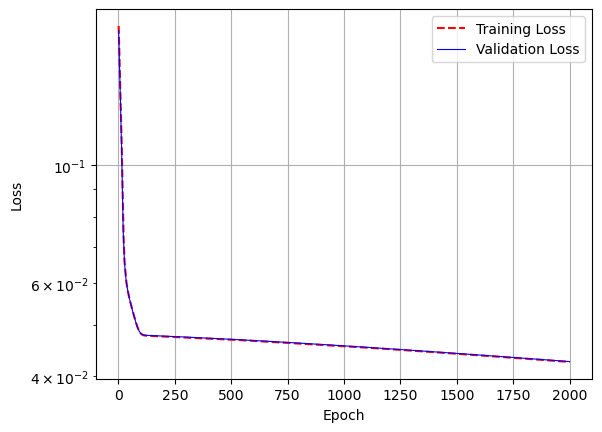

In [34]:
# plotting losses
dir_name_plot = dir_name_rnn+dir_sep+'plots'
if not os.path.isdir(dir_name_plot):
    os.makedirs(dir_name_plot)

# Visualize loss history
fig, ax = plot_losses(
    training_loss=train_loss_hist,
    val_loss=val_loss_hist,
    lr_change=lr_change,
    learning_rate_list=None
)

plt.savefig(dir_name_rnn+'{ds}plots{ds}loss_history.png'.format(ds=dir_sep), dpi=300, bbox_inches='tight')
plt.show()


data_idx : 2


2022-11-11 17:52:32.686023: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_755117"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024FlatMapDataset:28112"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_P

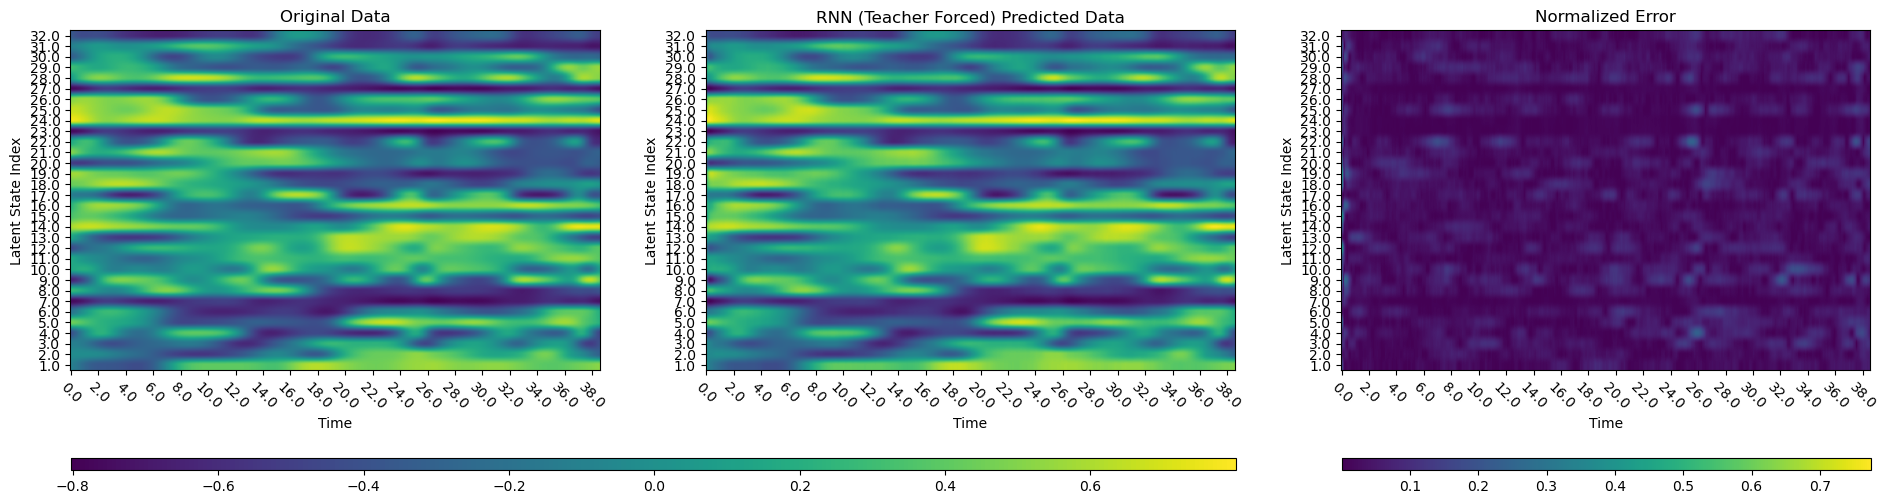

In [35]:
# data_type = 'training'
data_type = 'testing'

data_in = eval(data_type+'_data_rnn_input')
data_out = eval(data_type+'_data_rnn_output')

data_idx = np.arange(data_in.shape[0])
np.random.shuffle(data_idx)
data_idx = data_idx[0]
# data_idx = 3788
print('data_idx : {}'.format(data_idx))

# data_in = data_in[data_idx]
data_out = data_out[data_idx]

prediction = rnn_net.predict(data_in[data_idx:data_idx+1, :, :])

plot_reconstructed_data_KS(
    [data_out.shape[0]],
    dir_name_ae,
    data_out,
    prediction[0], delta_t, 1+np.arange(0, data_out.shape[1]),
    save_figs=False,
    normalization_constant_arr=normalization_arr,
    xticks_snapto=2,
    num_yticks=data_out.shape[1],
    ylabel=r'Latent State Index',
    ax1_title=r'Original Data',
    ax2_title=r'RNN (Teacher Forced) Predicted Data')

In [36]:
prediction.shape, data_out.shape

((1, 386, 32), (386, 32))